games.csv - датасет игр из steam

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("..//static//csv//games.csv")

Входные переменные: user_reviews (кол-во отзывов игроков; reviews в коде), price_original (цена на момент выхода; price в коде)

Выходная перменная: positive_ratio (отношение положительных отзывов к негативным; pos в коде)

In [72]:
from datetime import datetime as dt
from datetime import timedelta

import matplotlib.pyplot as plt
from skfuzzy import control as ctrl
import skfuzzy as fuzz

#входная переменная кол-ва отзывов с таким универсумом (от 0 до 100k)
reviews = ctrl.Antecedent(np.arange(0, 100000, 1), "reviews")

#входная переменная цены с таким универсумом (от 0 до 100 долларов)
price = ctrl.Antecedent(np.arange(0, 100, 0.01), "price")

#удалить пару игр, у которых цена больше 100 долларов, чтобы графики норм. были
df = df[df['price_original'] <= 100]

#удалить несколько игр, у которых больше 100k отзывов, чтобы графики норм. были
df = df[df['user_reviews'] <= 100000]

#выходная переменная позитивности с таким универсумом (от 0 до 100)
pos = ctrl.Consequent(np.arange(0, 100, 1), "pos")

## Лингвистические переменные и их визуализация

c:\AI labs\aimenv\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


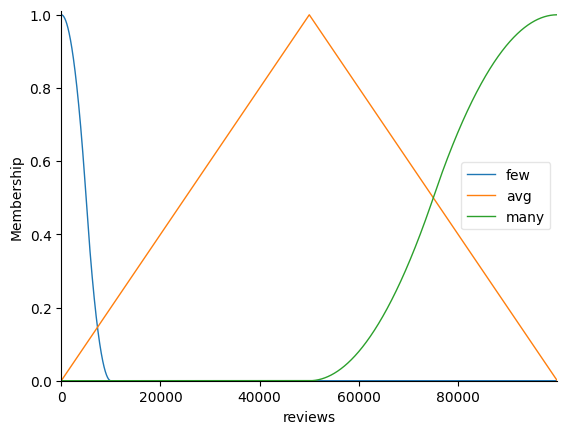

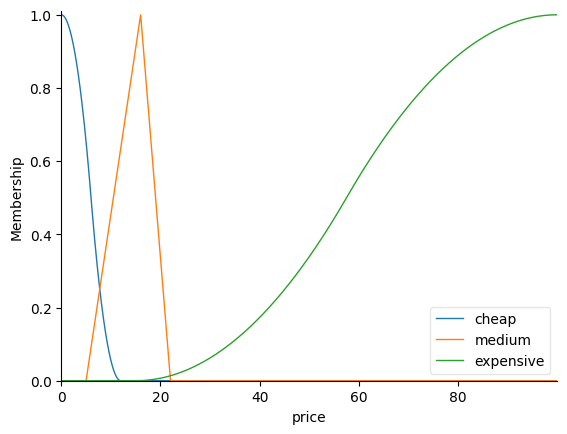

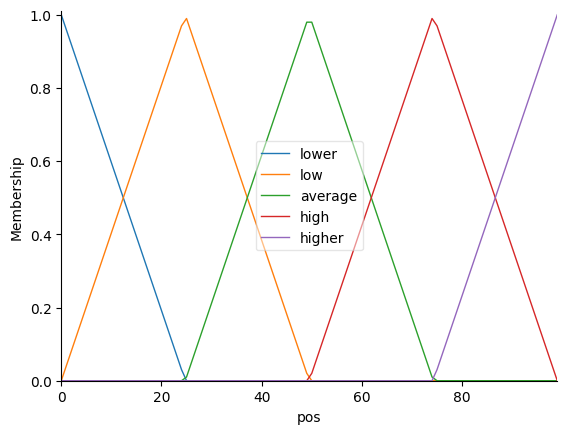

In [ ]:
#ЛИНГВИСТИЧЕСКАЯ ПЕР. КОЛ-ВО ОТЗЫВОВ

#автоматическое формирование нечёт. переменной отзывов, но с поправкой для many (s - ф-ия) 
reviews.automf(3, variable_type="quant", names=['few', 'avg', 'many'])
reviews["few"] = fuzz.zmf(reviews.universe, 0, 10000)

reviews["many"] = fuzz.smf(reviews.universe, reviews.universe.max()/2, reviews.universe.max())
reviews.view()



#ЛИНГВИСТИЧЕСКАЯ ПЕР. ЦЕНА

#От 0 до 12 долларов можно считать дёшево (переводил на рубли)
#z-функция
price["cheap"] = fuzz.zmf(price.universe, 0, 12)

#от 5 до 22 долларов можно считать средне (переводил на рубли)
#треуг. ф-ия
# 5  - левая вершина треугольника
# 15 - верхняя вершина
# 22 - правая вершина
price["medium"] = fuzz.trimf(price.universe, [5, 16, 22])

#больше 15 долларов можно считать дорого (переводил на рубли)
#s-функция
price["expensive"] = fuzz.smf(price.universe, 15, price.universe.max())

price.view()


#ЛИНГВИСТИЧЕСКАЯ ПЕР. СООТНОШЕНИЕ ПОЛОЖ./НЕГАТИВ. ОТЗЫВОВ
pos.automf(5, variable_type="quant")


pos.view()

## База нечётких правил

In [ ]:
rule1 = ctrl.Rule(reviews['many'] & price['cheap'], pos['high'])
rule2 = ctrl.Rule(reviews['many'] & price['medium'], pos['high']) 
rule3 = ctrl.Rule(reviews['many'] & price['expensive'], pos['high']) 

rule4 = ctrl.Rule(reviews['few'] & price['cheap'], pos['high']) 
rule5 = ctrl.Rule(reviews['few'] & price['medium'], pos['higher'])
rule6 = ctrl.Rule(reviews['few'] & price['expensive'], pos['average'])

rule7 = ctrl.Rule(reviews['avg'] & price['cheap'], pos['average'])
rule8 = ctrl.Rule(reviews['avg'] & price['medium'], pos['high'])
rule9 = ctrl.Rule(reviews['avg'] & price['expensive'], pos['average'])

fuzzy_rules = [
    rule1,
    rule2,
    rule3,
    rule4,
    rule5,
    rule6,
    rule7,
    rule8,
    rule9
]

fuzzy_sys = ctrl.ControlSystemSimulation(ctrl.ControlSystem(fuzzy_rules))


def fuzzy_pred(row):
    fuzzy_sys.input["reviews"] = row["user_reviews"]
    fuzzy_sys.input["price"] = row["price_original"]
    fuzzy_sys.compute()
    return fuzzy_sys.output["pos"]

from sklearn.model_selection import train_test_split

#Тестирование нечеткой системы на тестовой выборке
# Разделение данных на обучающую и тестовую выборки
X = df[['user_reviews', 'price_original']]
y = df['positive_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

test = pd.concat([X_test, y_test], axis=1)


print(test)

result_test = test.copy()
result_test["positive_ratio_pred"] = result_test.apply(fuzzy_pred, axis=1)
result_test

       user_reviews  price_original  positive_ratio
15251            46            0.99              95
13770           491            6.99              83
21390           365            0.00              76
16365            55            2.99              96
49100            78            0.00              74
...             ...             ...             ...
2652             55           14.99              74
30351            41            9.99              82
1810           4598           59.99              92
27959           115            2.99              73
2864             15            4.99              86

[10142 rows x 3 columns]


user_reviews  price_original  positive_ratio  positive_ratio_pred
15251            46            0.99              95            74.209477
13770           491            6.99              83            74.266425
21390           365            0.00              76            73.970238
16365            55            2.99              96            74.201895
49100            78            0.00              74            74.184970
...             ...             ...             ...                  ...
2652             55           14.99              74            90.615416
30351            41            9.99              82            85.367169
1810           4598           59.99              92            49.500000
27959           115            2.99              73            74.155404
2864             15            4.99              86            74.231120

[10142 rows x 4 columns]

In [75]:
#Оценка
import math
from sklearn import metrics
print(f"R^2 = {metrics.r2_score(test["positive_ratio"], result_test["positive_ratio_pred"])}")
print(f"RMSE = {math.sqrt(
    metrics.mean_squared_error(test["positive_ratio"], result_test["positive_ratio_pred"])
)}")

R^2 = -0.29858167190494145
RMSE = 20.894606342915804


Оценки показали, что построенная нечёткая система плохо справляется с предсказанием соотношения положительных отзывов к негативным. 

Средняя квадратичная ошибка составляет примерно 20%, что является достаточно большой ошибкой для диапазона от 0 до 100. 

Коэффициент детерминации получился отрицательным. Это означает, что система работает хуже, чем простое предсказание средним значением. Это говорит о том, что гипотезы о зависимости положительности отзывов от цены игры и количества отзывов, проявляемые в виде базы нечётких правил, неправильно отражают действительность. 


Возможно, что распределение отношений положительных отзывов к отрицательным имеет скорее случайный характер, поэтому оно не может быть описано с хорошей точностью нечёткими правилами

P.S. Было сделано более 5 попыток улучшить показатели засчёт изменения графиков функций и правил, но коэф. детерминации каждый раз всё равно был отрицательным (ещё больше по модулю, чем в данный момент)